# Preprocess

In [1]:
import os
import json
import bz2
from bz2 import decompress, BZ2Decompressor
from json import JSONDecoder, JSONDecodeError
import re

NOT_WHITESPACE = re.compile(r'[^\s]')

def get_files_by_type(rootdir = "data/2018", type = ".bz2"):
    for root, dirs, files in os.walk(rootdir):
        for name in files:
            if name.endswith((type)):
                full_path = os.path.join(root, name)
                yield full_path

def get_bz2_content(filepath):
    with open(filepath, 'rb') as file:
        decompressor = BZ2Decompressor()
        data = file.read()
        text = decompressor.decompress(data)
        return text

def decode_stacked(document, pos=0, decoder=JSONDecoder()):
    while True:
        match = NOT_WHITESPACE.search(document, pos)
        if not match:
            return
        pos = match.start()

        try:
            obj, pos = decoder.raw_decode(document, pos)
        except JSONDecodeError:
            break
        yield obj
        
def findkv(key, dictionary):
    for k, v in dictionary.items():
        if k == key:
            if v!=None:
                yield v.title()
        elif isinstance(v, dict):
            for result in findkv(key, v):
                yield result

In [69]:
from geotext import GeoText

def filter_bad_tweet_topics(tweet_text):
    #do some topic modeling with gensim
    #if tweet is political remove it
    #if tweet is not travel related - remove it
    pass

def get_cities_and_countries(file_content):
    cities = []
    countries = []
    places_in_text = GeoText(obj.get('text', "").title())
    cities = cities + places_in_text.cities
    countries = countries + places_in_text.countries
    val = list(findkv('location', obj))
    if val!=[]:
        for p in val:
            places = GeoText(p)
            cities = cities + places.cities
            countries = countries + places.countries
    return (cities, countries)

all_cities_and_countries = []
for jfile_path in get_files_by_type():
    data = get_bz2_content(jfile_path).decode("utf-8")
    for obj in decode_stacked(data):
        cities, countries = get_cities_and_countries(obj)
        if cities==[] and countries==[]:
            pass
        else:
            record = {}
            record['created_at'] = obj['created_at']
            record['cities'] = cities
            record['countries'] = countries
            all_cities_and_countries.append(record)
        
with open("location_results.json", 'w') as result_file:
    json.dump(all_cities_and_countries, result_file)     
            

NameError: name 'get_files_by_type' is not defined

# Transform & Analyze

In [120]:
#read json file with saved location data and load it to pandas array
#transform city and coutry names to coutry codes according to ISO 
from iso3166 import countries
from geopy.geocoders import Nominatim
import textdistance

geolocator = Nominatim(user_agent="twitter-location-analyzer")

def get_iso_from_name(coutry):
    #td: find all and get one with the less hamming distance
    cou = countries.get(coutry.capitalize(), "None")
    if cou!="None":
        return cou.alpha2
    
    cou = countries.get(coutry.upper(), "None")
    if cou!="None":
        return cou.alpha2
        
    for c in countries:
        if coutry.upper() in c:
            return c.alpha2
    for c in countries:
        if coutry in c.name:
            return c.alpha2
    return None

def get_iso_from_any_address(address):
    try:
        location = geolocator.geocode(address)
        if location == None:
            return address
        location2 = geolocator.reverse(str(location.latitude) + "," + str(location.longitude), language='en')
        if location2 == None:
            return address
        possible_code = get_iso_from_name(location2.raw['address']['country'])
        if possible_code!=None:
            return possible_code
        else:
            possible_code = get_iso_from_name(location2.raw['address']['country_code'])
        if possible_code!=None:
            return possible_code
        else:
            return address
    except:
        return address


In [117]:
get_iso_from_any_address("India")
get_iso_from_name("India")
countries.get("India")

'India'

In [121]:
#now reformat all found names into country codes and put them in dataFrame
import pandas as pd
import json 

all_cities_map = dict()
all_countries_map = dict()

with open("location_results.json", 'r') as result_file:
    data = json.load(result_file)
    for tweet in data:
        for c in set(tweet['countries']):
            if c not in all_countries_map:
                #find what is the coutry code
                code = get_iso_from_name(c)
                if code == None:
                    code = get_iso_from_any_address(c)
                all_countries_map[c] = code
                
        for c in set(tweet['cities']):
            if c not in all_cities_map:
                #find what is the coutry code
                code = get_iso_from_any_address(c)
                all_cities_map[c] = code
                
with open("all_cities_map.json", 'w') as result_file:
    json.dump(all_cities_map, result_file)   

with open("all_countries_map.json", 'w') as result_file:
    json.dump(all_countries_map, result_file)  


# Display

In [1]:
import json
all_countries_map = []
all_cities_map = []
with open("all_cities_map.json", 'r') as result_file:
    all_cities_map = json.load(result_file)   

with open("all_countries_map.json", 'r') as result_file:
    all_countries_map = json.load(result_file) 

In [2]:
#display simple list by number of destinations count
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#display country mentions
country_mentions = dict()

with open("location_results.json", 'r') as result_file:
    data = json.load(result_file)
    for tweet in data:
        for c in set(tweet['countries']):
            country_code = all_countries_map[c]
            if country_code in country_mentions:
                country_mentions[country_code]+=1
            else:
                country_mentions[country_code]=1
                
        for c in set(tweet['cities']):
            country_code = all_cities_map[c]
            if country_code in country_mentions:
                country_mentions[country_code]+=1
            else:
                country_mentions[country_code]=1
                




In [3]:
found_coutries = { ckey: country_mentions[ckey] for ckey in country_mentions if len(ckey)==2}

df = pd.DataFrame.from_dict({'country': list(found_coutries.keys()), 'count': list(found_coutries.values())})

#filter by continent 
codes_list = pd.read_csv('country-and-continent-codes-list-csv_csv.csv')
asia_codes = codes_list[codes_list['Continent_Name']=='Asia' ]
europe_codes = codes_list[codes_list['Continent_Name']=='Europe' ]

europe_destinations = df[df['country'].isin(list(europe_codes['Two_Letter_Country_Code']))].sort_values('count', ascending=False)
asia_destinations = df[df['country'].isin(list(asia_codes['Two_Letter_Country_Code']))].sort_values('count', ascending=False)

print(europe_destinations.sort_values(by='count', ascending=False).head())
print(asia_destinations.sort_values(by='count', ascending=False).head())


   country  count
8       FR   4189
12      GB   4181
0       ES   3350
2       TR   1496
27      PT    960
   country  count
6       IN   4544
13      TH   2852
7       JP   2174
1       ID   2000
2       TR   1496


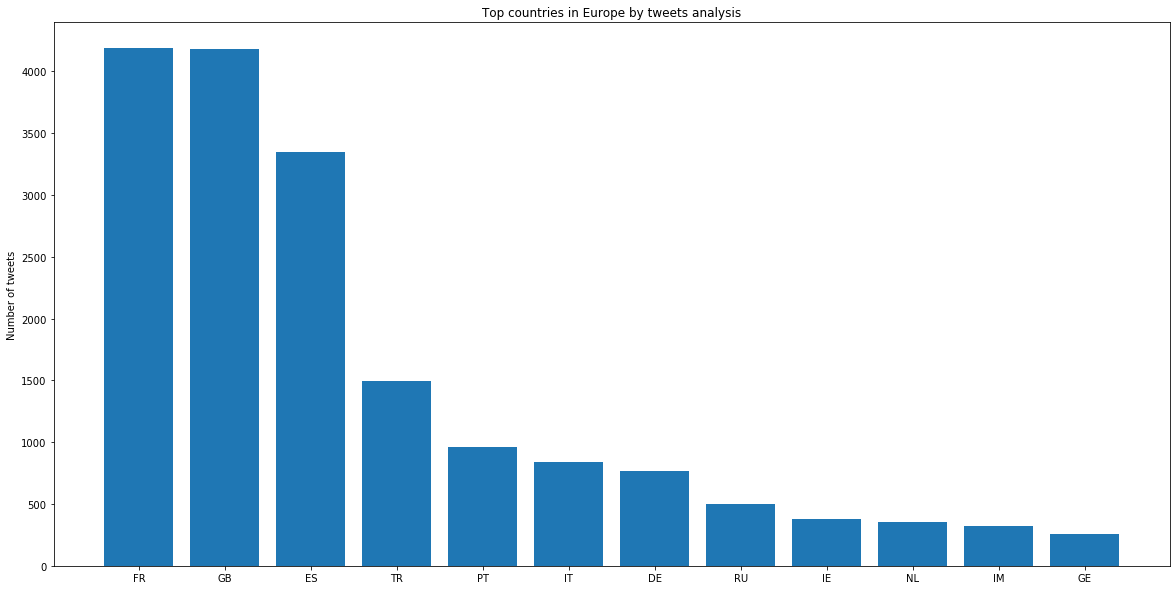

In [138]:
matplotlib.rcParams['figure.figsize'] = [20, 10]

top_how_many = 12
plt.ylabel('Number of tweets')
plt.title('Top countries in Europe by tweets analysis')
plt.bar(range(top_how_many), list(europe_destinations['count'])[:top_how_many], align='center')#len(country_mentions)
plt.xticks(range(top_how_many), list(europe_destinations['country'])[:top_how_many])#len(country_mentions)
plt.show()

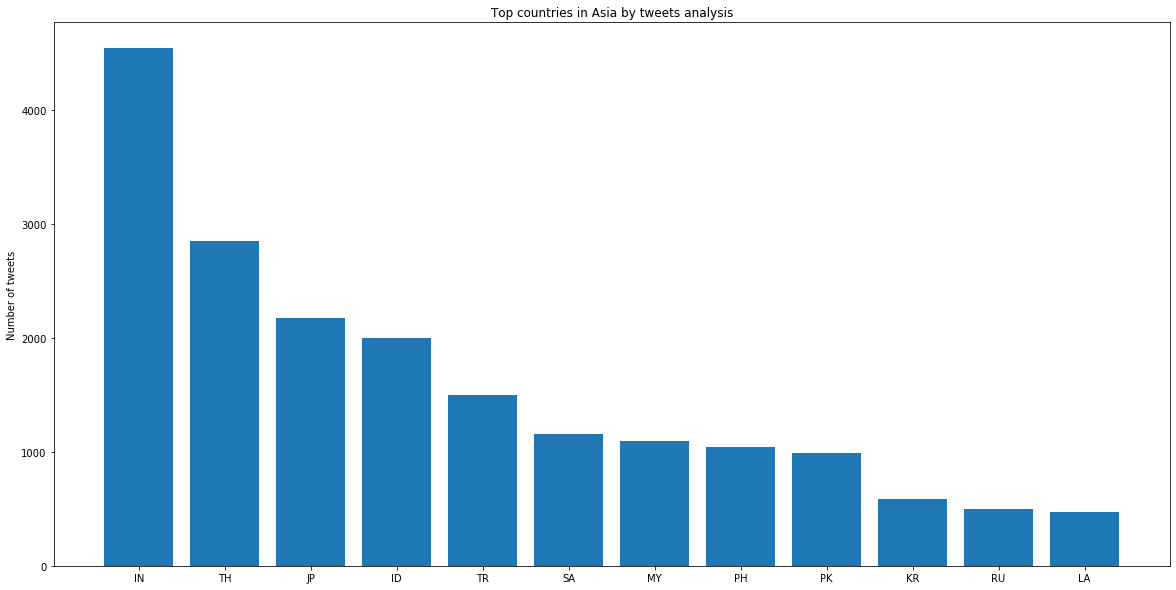

In [140]:
matplotlib.rcParams['figure.figsize'] = [20, 10]

top_how_many = 12
plt.ylabel('Number of tweets')
plt.title('Top countries in Asia by tweets analysis')
plt.bar(range(top_how_many), list(asia_destinations['count'])[:top_how_many], align='center')#len(country_mentions)
plt.xticks(range(top_how_many), list(asia_destinations['country'])[:top_how_many])#len(country_mentions)
plt.show()

## TODOs

* Improve country code detection (British Indian Ocean Teritory as example)
* Detect if the tweet is related to traveling only (remove political tweets for ex)
* Better visualization with superset

## Notes

Data set is disparsed because some coutries use more twitter that others & some people use more english that others etc.

It is hard to detect if tweet is strictly travel oriented or it is posted by locals etc

https://altair-viz.github.io/gallery/choropleth_repeat.html

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6002102/

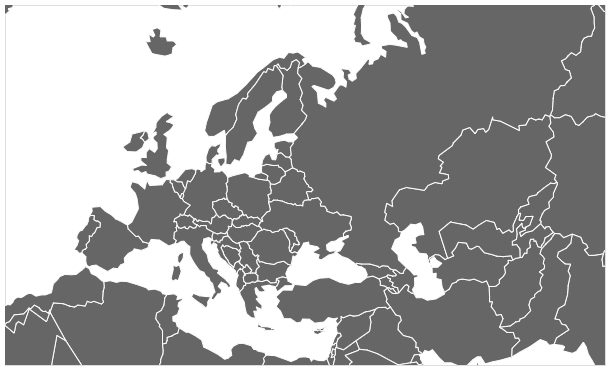

In [15]:
import altair as alt
alt.renderers.enable('notebook')

from vega_datasets import data

source = alt.topo_feature(data.world_110m.url, 'countries')

base = alt.Chart(source).mark_geoshape(
    fill='#666666',
    stroke='white'
).properties(
    width=600,
    height=360,
    
)

projections = ['equirectangular', 'mercator', 'orthographic', 'gnomonic']
charts = [base.project(proj).properties(title=proj)
          for proj in projections]

base.project(
    type='orthographic',
    scale=450,
    rotate=[-31, -54]
)
#alt.concat(*charts, columns=2)